# Lab of computational physics - EXR10

#### Barone Francesco Pio, AY 2021/22 UniPD

In [1]:
# I will place the files for this notebook in a dedicated subdirectory
%cd ./10data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

/home/baronefr/Documents/lab_local/10data


1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

Decay simulation terminated at t = 2334 s, after 2334 iterations


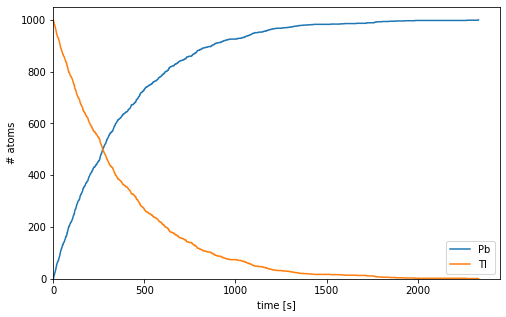

In [2]:
### simulating A -> B decay ###

#  Namely we want to compute the decay of Pb to Tl, but I write this function
#  for a generic A -> in order to reuse it in other circumstances.

A_init = 1000                   # initial number of A atoms (Pb)
tau = 3.052 * 60 / math.log(2)  # half_life = log(2) * tau
dt = 1                          # delta t of simulation

# define the probability of decay at given t
def decay_probability(t):  return 1 - (2**(-t/tau)) 

# generating the probabilities of decay for each atom A
fu = np.random.uniform(0,1,A_init)


B = [ 0 ]
tt = 0        # current time in simulation
decayed = 0   # counter of decayed particles

while decayed < A_init:
    tt += dt
    decayed = int( np.sum(fu < decay_probability(tt) ) ) # number of particles that has decayed since t = 0
    B.append(decayed)

print(f'Decay simulation terminated at t = {tt} s, after {len(B)-1} iterations')

B[-1] = A_init    # fix the last value exceeding A_init
B = np.array(B)
A = A_init - B
t = np.arange(0,tt+dt,dt)

plt.figure(figsize=(8, 5))
plt.plot(t, B , label ='Pb')
plt.plot(t, A , label ='Tl')
plt.xlabel('time [s]');  plt.ylabel('# atoms');
plt.legend(); plt.xlim(0, t[-1]*21/20); plt.ylim(0, A_init*21/20);  plt.show();

Given $$p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$$
we compute
$$
\int_{0}^{x(z)} p(t') dt' = \frac{\ln 2}{\tau} \cdot \frac{-1}{\ln 2} \big[2^{-t/\tau} \big]^{x(z)}_0 = 2^{-x(z)/\tau} -1 = z
$$

$$
x(z) = - \tau\cdot\log_2{(1-z)}
$$

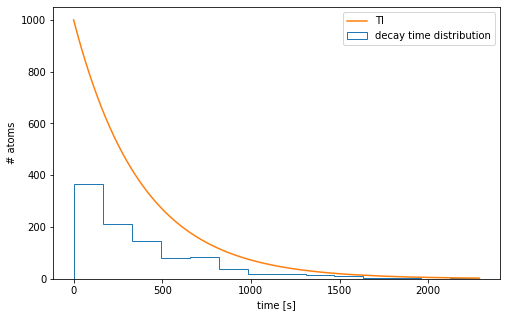

In [3]:
def icdf(z): return -tau*np.log2(1 - z)   # the function from my previous analytical solution of p(t) integral

x = np.random.random(A_init)
x = np.sort(x)
y = icdf(x)   # times of decay of 1000 atoms drawn from the distribution (already sorted!)

plt.figure(figsize=(8, 5))
plt.hist(y, histtype='step',bins=14, label = 'decay time distribution')

plt.plot(y, (1-x)*A_init, label='Tl')

plt.xlabel('time [s]');    plt.ylabel('# atoms');
plt.legend(); plt.show();

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{\theta}{2} } = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [4]:
# std physical constants
a0 =  5.9e-11   # [m]
e  = -1.6e-19   # [C]

# simulation parameters
E = 7.7     # Energy of the beam [MeV]
Z = 79      # Target Z (gold)
N = int(1e7)
sigma = a0/100
E *= abs(e) * 1e6   #    converting E to Joule

# b is represented by a 2D gaussian distribution
x, y = np.random.normal(0, sigma, N), np.random.normal(0, sigma, N)
b = np.sqrt( x**2 + y**2 )

theta = 2*np.arctan((Z*(e**2))/(2*np.pi*(8.85e-12)*E*b))
bounced_back = np.sum(theta > np.pi/2)

print(f'{bounced_back} over {N} particles bounced back ({bounced_back*100/N}%)')

12306 over 10000000 particles bounced back (0.12306%)


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [5]:
def f(x): return (np.sin(1/(x*(2-x))))**2
x_delta = 2 - 0   # is b-a
y_delta = 1 - 0   # since this function has image in [0,1]

N = 10**5         # number of point to sample

##### hit-miss method
x, y = x_delta*np.random.random(N), y_delta*np.random.random(N)
hits = np.sum( y<f(x) )
I   = x_delta*y_delta*hits/N
err = x_delta*y_delta*np.sqrt(hits)/N
print('hit-miss   ->', I, '+-', err)

##### mean value method
x   = x_delta*np.random.random(N)   # <- already computed before
I   = x_delta*y_delta*np.sum( f(x) )/N
err = x_delta*y_delta*np.sqrt( np.var(f(x))/N )
print('mean value ->', I, '+-', err)

hit-miss   -> 1.45242 +- 0.00538965676087077
mean value -> 1.4492470624801534 +- 0.001670154644305202


We see that the mean value method esteems the integral with a smaller confidence interval.

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [6]:
N = 10**5

def f(x_vect): return (np.sum(x_vect**2) <= 1)   
    # This function works for any dimension d of the vector x

def integral_d(d = 2):
    sm , x = 0,  2*np.random.random(size=(N, d))-1
    for point in x: sm += f(point)
    return (2**d)*sm/N

print('2D circle:', integral_d(2) )     # should be = pi
print('10D circle:', integral_d(10) )   

2D circle: 3.1348
10D circle: 2.36544


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [7]:
def f(x): return (x**(-1/2))/(np.exp(x)+1)    # integrand function
def w(x): return 1/np.sqrt(x)                 # chosen w function

N = 10**5

# compute the integral of w(x)
x = np.random.random(N)
integral_w = np.sum(w(x))/N

# compute the integral of f(x) with importance sampling
x = np.random.random(N)  # generate new samples for the new integral evaluation
x = x**2                 # we need to invert the sampling, since we took the square root before
I = np.sum(f(x)/w(x))*integral_w/N

print(I)

0.8392752668536594


End of file.